In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender

# Метрики
from metrics import precision_at_k

In [2]:
data = pd.read_csv('../../Теория/Lesson_2/data/retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [4]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [5]:
def random_recommendation(items, n=5):
    """Случайные рекомендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [6]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекомендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    # your_code
    
    recs = np.random.choice(items_weights['item_id'], size=n, 
                            replace=False, p=items_weights['weight'])
    
    return recs.tolist()

In [7]:
%%time

weights = np.log(data_train.groupby('item_id', sort=False)['sales_value'].sum() + 1)
weights_normalized = weights / weights.sum()

items_weights = pd.DataFrame(data=np.array([data_train['item_id'].unique(), weights_normalized]).T,
                             columns=['item_id', 'weight'])

items_weights['item_id'] = items_weights['item_id'].astype('int')

items_weights.head()

CPU times: user 62.5 ms, sys: 379 µs, total: 62.9 ms
Wall time: 62.4 ms


,item_id,weight
0,1004906,0.000037
1,1033142,0.000032
2,1036325,0.000023
3,1082185,0.000042
4,8160430,0.000024


In [8]:
%%time

result['weighted_random_recommendation'] = result['user_id'].\
        apply(lambda x: weighted_random_recommendation(items_weights, n=5))

result.head(2)

CPU times: user 1.3 s, sys: 0 ns, total: 1.3 s
Wall time: 1.29 s


,user_id,actual,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[931512, 965693, 10457375, 1003354, 9297599]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[6979653, 903674, 866439, 9526279, 12384025]"


## Задание 2. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая случаный на топ-5000 товаров
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.

### 1. Popularity-based

Сделаем рекомендации по популярности, но популярность будем  
считать не по количеству потраченных денег на товар, как считали  
на уроке, а по количеству фактов покупки товара:

In [9]:
def popularity_recommendation_revised(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.loc[data['quantity'] != 0].groupby('item_id', sort=False)['quantity'].count().reset_index()
    popular.sort_values('quantity', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [10]:
%%time

popular_recs = popularity_recommendation_revised(data_train, n=5)

result['popular_recommendation_revised'] = result['user_id'].apply(lambda x: popular_recs)

result.head(2)

CPU times: user 80.2 ms, sys: 16.1 ms, total: 96.2 ms
Wall time: 95.9 ms


,user_id,actual,weighted_random_recommendation,popular_recommendation_revised
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[931512, 965693, 10457375, 1003354, 9297599]","[1082185, 6534178, 1029743, 995242, 1106523]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[6979653, 903674, 866439, 9526279, 12384025]","[1082185, 6534178, 1029743, 995242, 1106523]"


### 2. Случайный на топ-5000 товаров

In [11]:
popularity = data_train.groupby('item_id', sort=False)['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 6666
data_train

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2282320,222,41297772783,635,1120741,1,0.59,304,0.00,1716,91,0.0,0.0
2282321,462,41297773713,635,6666,1,1.99,304,0.00,2040,91,0.0,0.0
2282322,462,41297773713,635,995242,1,1.00,304,-0.89,2040,91,0.0,0.0
2282323,462,41297773713,635,10180324,1,3.00,304,-0.29,2040,91,0.0,0.0


In [12]:
items = data_train['item_id'].unique()

result['top5000_random_recommendation'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))

result.head(2)

,user_id,actual,weighted_random_recommendation,popular_recommendation_revised,top5000_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[931512, 965693, 10457375, 1003354, 9297599]","[1082185, 6534178, 1029743, 995242, 1106523]","[1138487, 985579, 922907, 888014, 869728]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[6979653, 903674, 866439, 9526279, 12384025]","[1082185, 6534178, 1029743, 995242, 1106523]","[908940, 989354, 5572738, 886125, 1131438]"


### 3. Item-item recommender adjusting

In [13]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix)


In [14]:
# создаем словари мапинга между id бизнеса к строчному id матрицы

userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

Помимо подбора параметра К, сделаем фильтрацию по товару 6666, которого  
нет в тесте:

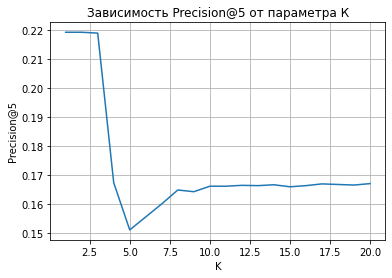

CPU times: user 28.4 s, sys: 137 ms, total: 28.5 s
Wall time: 5.44 s


In [15]:
%%time

scores = np.array([])
ks = np.arange(1, 21)

for k in ks:

    model = ItemItemRecommender(K=k) # K - кол-во билжайших соседей


    model.fit(sparse_user_item.T.tocsr(),  # На вход item-user matrix
              show_progress=False)


    result['itemitem'] = result['user_id'].apply(lambda user_id: [id_to_itemid[rec[0]]  
                                                              for rec in model.recommend(userid=userid_to_id[user_id], 
                                                                user_items=sparse_user_item,   # на вход user-item matrix
                                                                N=5, 
                                                                filter_already_liked_items=False, 
                                                                filter_items=[itemid_to_id[6666]], 
                                                                recalculate_user=False)
                                                                             ])
    scores = np.append(scores, round(result.apply(lambda x: precision_at_k(x['itemitem'], x['actual']), axis=1).mean(),4))

plt.plot(ks, scores)
plt.title('Зависимость Precision@5 от параметра К')
plt.xlabel('K')
plt.ylabel('Precision@5')
plt.grid()
plt.show()

In [16]:
scores[:3]

array([0.2193, 0.2193, 0.219 ])

Наивысшую метрику precision@5 получили модели с К=1 и К=2.  
Для разнообразия выберем К=2, т.к. К=1 мы использовали на уроке:

In [17]:
model = ItemItemRecommender(K=2) # K - кол-во билжайших соседей
model.fit(sparse_user_item.T.tocsr(),  # На вход item-user matrix
              show_progress=False)

result['itemitem'] = result['user_id'].apply(lambda user_id: [id_to_itemid[rec[0]]  
                                                              for rec in model.recommend(userid=userid_to_id[user_id], 
                                                                user_items=sparse_user_item,   # на вход user-item matrix
                                                                N=5, 
                                                                filter_already_liked_items=False, 
                                                                filter_items=[itemid_to_id[6666]], 
                                                                recalculate_user=False)
                                                                             ])

result.head(2)

,user_id,actual,weighted_random_recommendation,popular_recommendation_revised,top5000_random_recommendation,itemitem
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[931512, 965693, 10457375, 1003354, 9297599]","[1082185, 6534178, 1029743, 995242, 1106523]","[1138487, 985579, 922907, 888014, 869728]","[1082185, 995242, 1029743, 840361, 904360]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[6979653, 903674, 866439, 9526279, 12384025]","[1082185, 6534178, 1029743, 995242, 1106523]","[908940, 989354, 5572738, 886125, 1131438]","[1082185, 1098066, 6534178, 826249, 1127831]"


Сравним метрики полученных моделей:

In [18]:
for name_col in ('weighted_random_recommendation', 'popular_recommendation_revised', 'top5000_random_recommendation', 'itemitem'):
    print(f"{round(result.apply(lambda row: precision_at_k(row[name_col], row['actual']), axis=1).mean(),4)}:{name_col}")

0.0014:weighted_random_recommendation
0.2056:popular_recommendation_revised
0.0062:top5000_random_recommendation
0.2193:itemitem


Выводы:  
- добавление весов товарам при случайных рекомендациях чуть повысило метрику,  
но это, скорее, в пределах абсолютной погрешности random_seed;  
- выдача случайных рекомендаций из 5000 популярных товаров ожидаемо улучшила  
рекомендации, но относительно других методов всё равно оказалась слабой;
- изменение принципа формирования популярных рекомендаций ощутимо подняло  
метрику и приблизило её к лидеру;
- подбор параметра К модели ItemItemRecommender и фильтрация рекомендаций,  
отсутствующих в тесте, практически повторили результат own_purchases, полученный  
на уроке. По сути, это одна и та же модель, только на уроке мы сразу взяли К=1,  
а здесь лишь убедились, что это значение параметра даёт наивысшую метрику.